# TimeGPT

Source: https://www.datacamp.com/datalab/w/7d3e3b8e-a74b-483d-8326-12d070aebdca/edit

In [1]:
%%capture
%pip install nixtla>=0.5.1
%pip install yfinance

In [22]:
import pandas as pd
import yfinance as yf
from nixtla import NixtlaClient
import os

timegpt_api_key = os.environ["TIMEGPT_API_KEY"]

# Setup NixtlaClient
nixtla_client = NixtlaClient(api_key = timegpt_api_key)


# Downloading Amazon stock price data
ticker = 'AMZN'
amazon_stock_data = yf.download(ticker)
amazon_stock_data = amazon_stock_data.reset_index()
amazon_stock_data.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']

# Displaying the dataset
amazon_stock_data.head()

[*********************100%***********************]  1 of 1 completed


,Date,Close,High,Low,Open,Volume
0,1997-05-15,0.097917,0.125000,0.096354,0.121875,1443120000
1,1997-05-16,0.086458,0.098958,0.085417,0.098438,294000000
2,1997-05-19,0.085417,0.088542,0.081250,0.088021,122136000
3,1997-05-20,0.081771,0.087500,0.081771,0.086458,109344000
4,1997-05-21,0.071354,0.082292,0.068750,0.081771,377064000


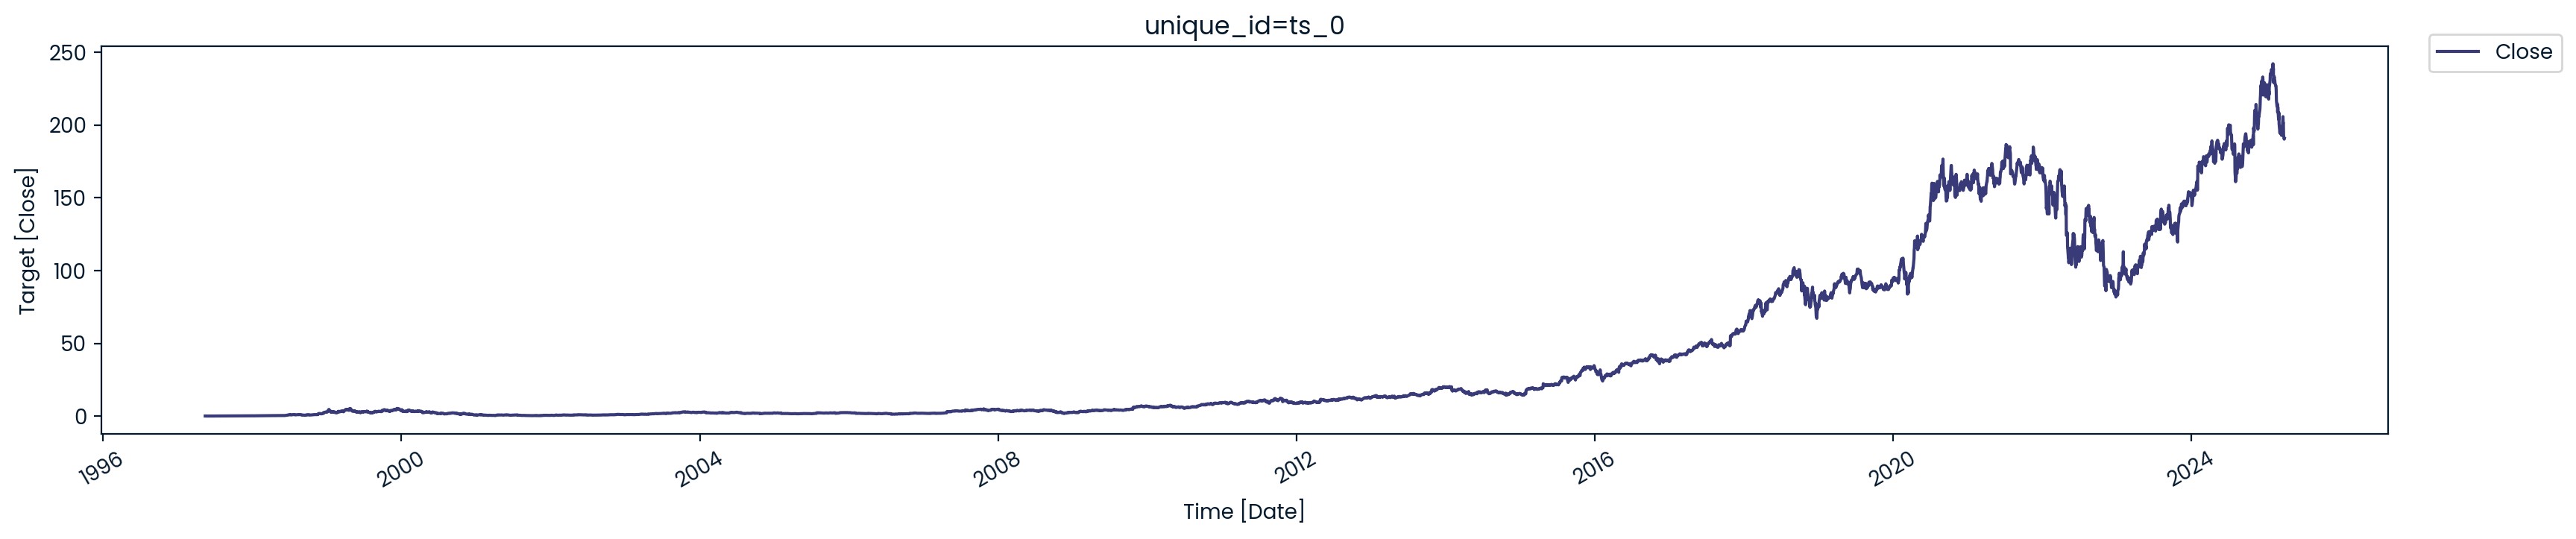

In [23]:
nixtla_client.plot(amazon_stock_data, time_col='Date', target_col='Close')

In [24]:
# Ensure the 'Date' column is in datetime format
amazon_stock_data['Date'] = pd.to_datetime(amazon_stock_data['Date'])

# Set the 'Date' column as the index
amazon_stock_data.set_index('Date', inplace=True)

# Resample the data to ensure it matches the 'B' (business day) frequency
amazon_stock_data = amazon_stock_data.resample('B').asfreq()

# Fill missing values if any (optional, depending on your use case)
amazon_stock_data['Close'].fillna(method='ffill', inplace=True)

In [35]:
amazon_stock_data['High'].fillna(method='ffill', inplace=True)
amazon_stock_data['Low'].fillna(method='ffill', inplace=True)

In [36]:


# Now call the forecast function
model = nixtla_client.forecast(df=amazon_stock_data, model='timegpt-1', h=24, freq="B", time_col='Date', target_col='Low')
model.tail()

,Date,TimeGPT
19,2025-04-29,189.51633
20,2025-04-30,190.08302
21,2025-05-01,193.08519
22,2025-05-02,193.62338
23,2025-05-05,193.44075


In [30]:
print(amazon_stock_data.columns)

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')


In [39]:
print(dir(nixtla_client))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_client_kwargs', '_distributed_cross_validation', '_distributed_detect_anomalies', '_distributed_detect_anomalies_online', '_distributed_forecast', '_get_model_params', '_get_request', '_is_azure', '_make_partitioned_requests', '_make_request', '_make_request_with_retries', '_maybe_assign_feature_contributions', '_maybe_assign_weights', '_maybe_override_model', '_model_params', '_retry_strategy', '_run_validations', 'cross_validation', 'delete_finetuned_model', 'detect_anomalies', 'detect_anomalies_online', 'finetune', 'finetuned_models', 'forecast', 'plot', 'supported_models', 'usage', 'validate_api_key']


In [41]:
import pandas as pd

def read_tsf_from_file(file_path):
    data = []
    start_date = pd.to_datetime('2002-01-01 00:00:00')

    # Open and read the file from the directory
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('T'):
                parts = line.strip().split(':')
                unique_id = parts[0] + '-' + parts[1]
                values = list(map(float, parts[3].split(',')[:-1]))
                
                # Generate datetime index at half-hour intervals
                periods = len(values)
                date_range = pd.date_range(start=start_date, periods=periods, freq='30min')
                
                # Append to data list
                for dt, value in zip(date_range, values):
                    data.append([unique_id, dt, value])

    # Convert the list of data into a DataFrame
    return pd.DataFrame(data, columns=['unique_id', 'ds', 'y'])

# Example usage
file_path = 'australian_electricity_demand_dataset.tsf'
demand_df = read_tsf_from_file(file_path)

# Display the dataframe
demand_df.head()

,unique_id,ds,y
0,T1-NSW,2002-01-01 00:00:00,5714.045004
1,T1-NSW,2002-01-01 00:30:00,5360.189078
2,T1-NSW,2002-01-01 01:00:00,5014.835118
3,T1-NSW,2002-01-01 01:30:00,4602.755516
4,T1-NSW,2002-01-01 02:00:00,4285.179828


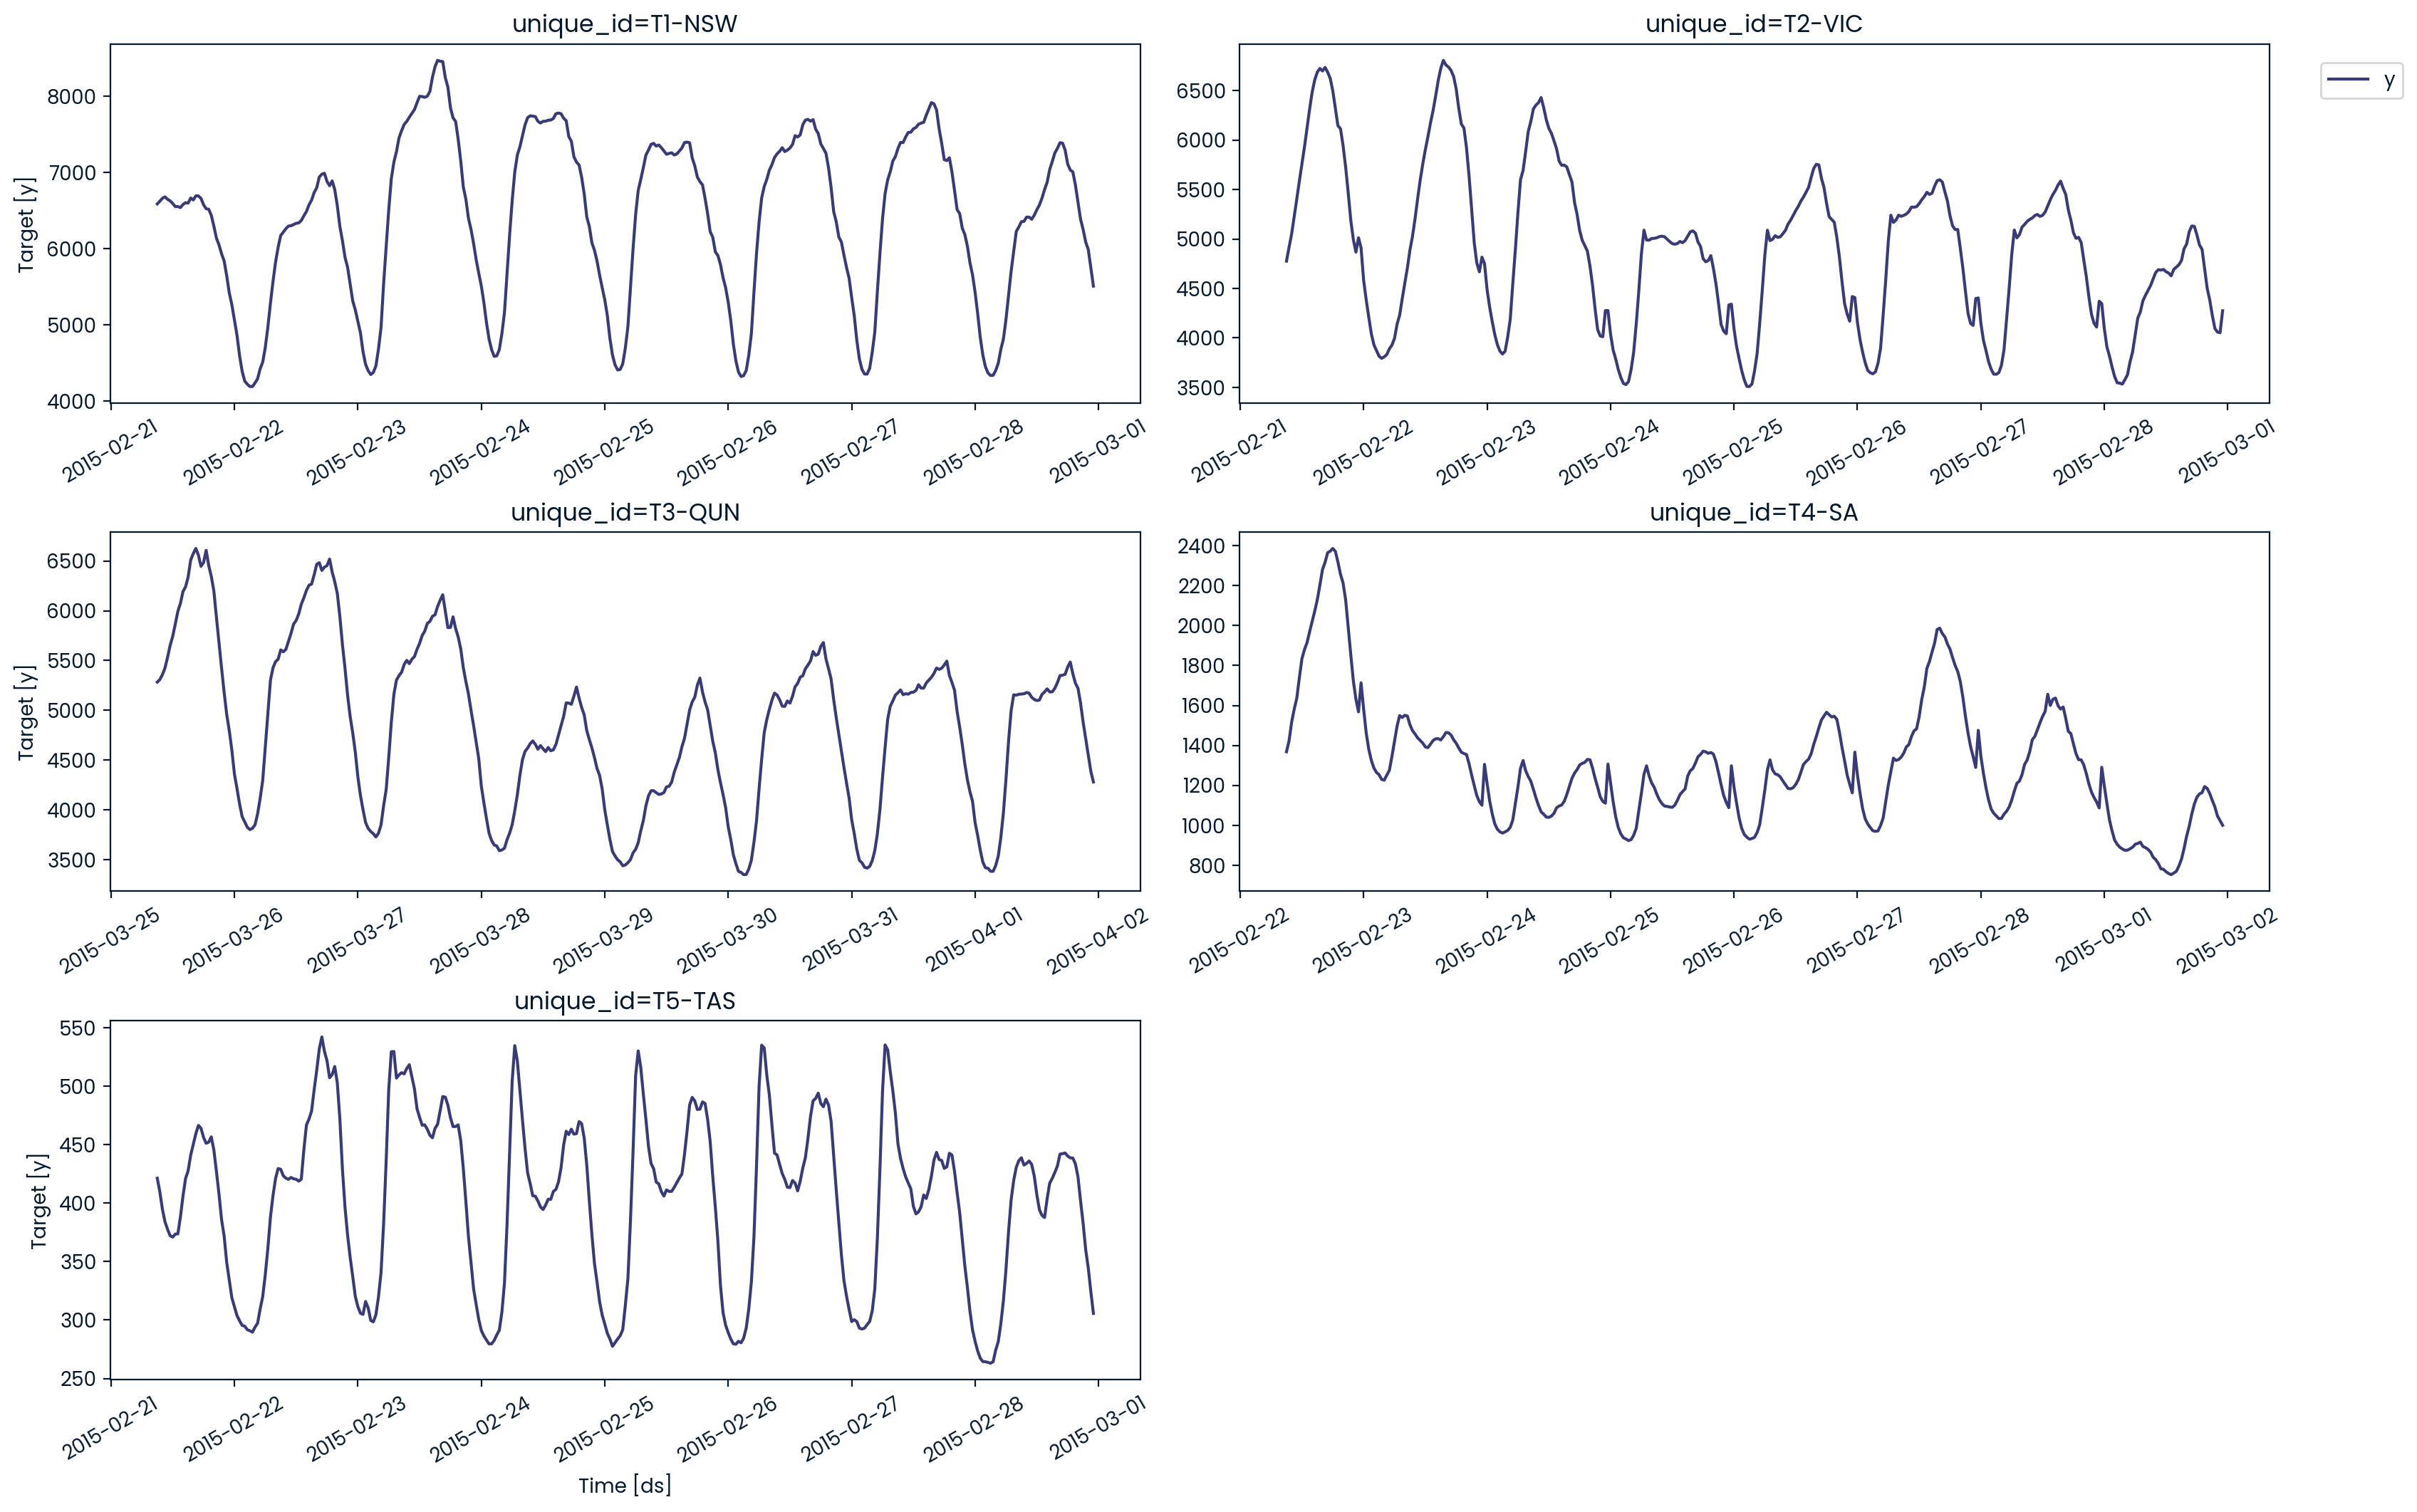

In [42]:
nixtla_client.plot(
    demand_df, 
    max_insample_length=365, 
)

In [44]:
# Detect anomalies
anomalies_df = nixtla_client.detect_anomalies(
    demand_df, 
    time_col='ds', 
    target_col='y', 
    #freq='H', 
)


In [45]:
anomalies_df[anomalies_df["anomaly"]==1].head()

,unique_id,ds,y,TimeGPT,TimeGPT-hi-99,TimeGPT-lo-99,anomaly
162,T1-NSW,2002-01-07 08:30:00,7483.997440,4857.0080,7412.3374,2301.6782,True
163,T1-NSW,2002-01-07 09:00:00,7606.604012,4871.6600,7426.9897,2316.3306,True
164,T1-NSW,2002-01-07 09:30:00,7636.640416,4947.0986,7502.4280,2391.7690,True
165,T1-NSW,2002-01-07 10:00:00,7660.476694,4974.2200,7529.5500,2418.8906,True
166,T1-NSW,2002-01-07 10:30:00,7685.436958,4957.2744,7512.6040,2401.9448,True


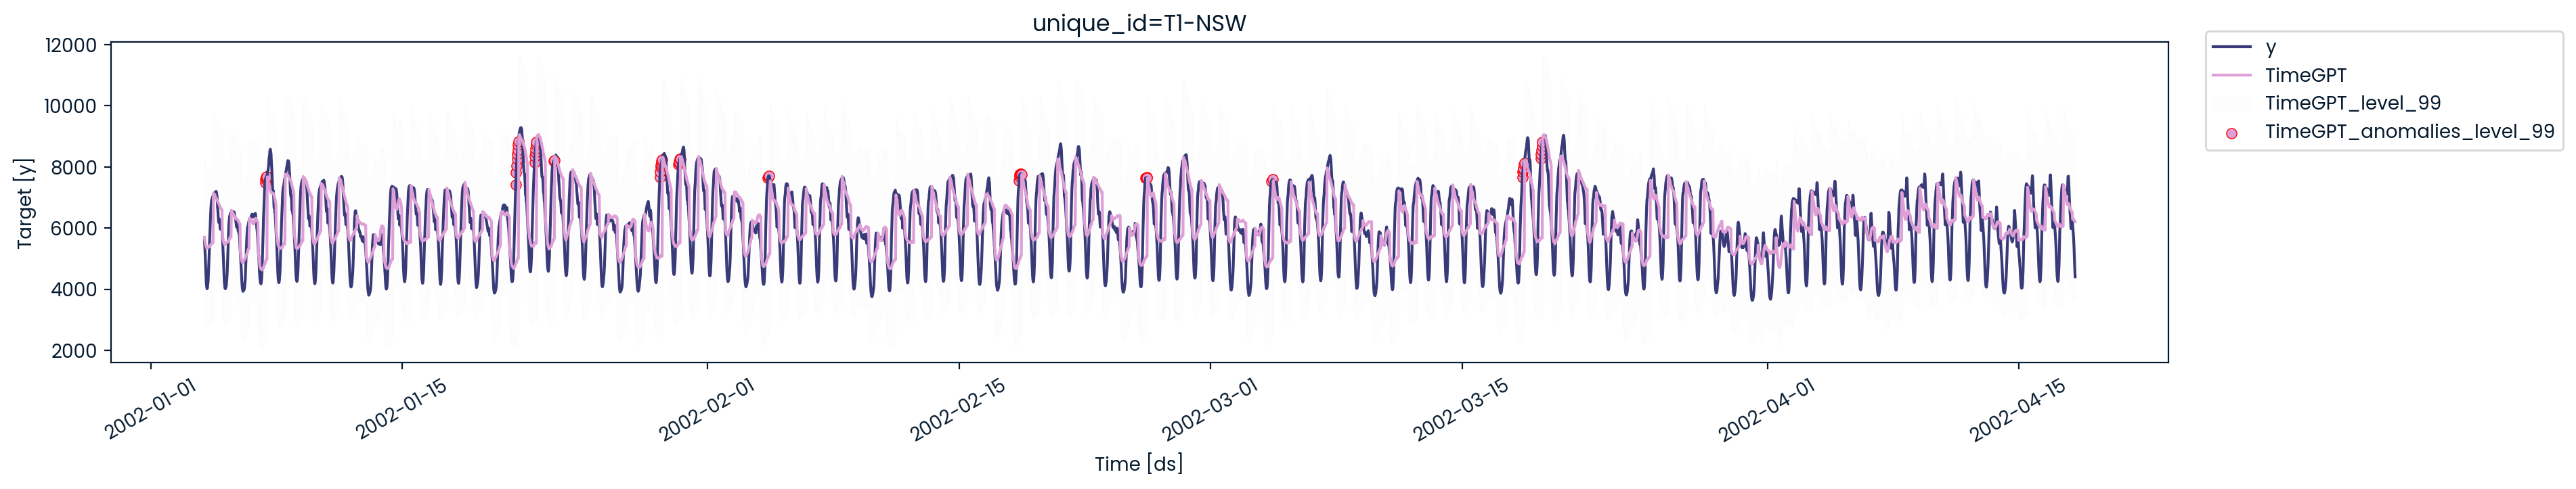

In [46]:
# Plot anomalies
nixtla_client.plot(
    demand_df[demand_df["unique_id"]=="T1-NSW"][0:5000], 
    anomalies_df[anomalies_df["unique_id"]=="T1-NSW"][0:5000],
    time_col='ds', 
    target_col='y',
    
)

In [47]:
T1_df = demand_df[demand_df["unique_id"]=="T1-NSW"]
T1_df.head()

,unique_id,ds,y
0,T1-NSW,2002-01-01 00:00:00,5714.045004
1,T1-NSW,2002-01-01 00:30:00,5360.189078
2,T1-NSW,2002-01-01 01:00:00,5014.835118
3,T1-NSW,2002-01-01 01:30:00,4602.755516
4,T1-NSW,2002-01-01 02:00:00,4285.179828


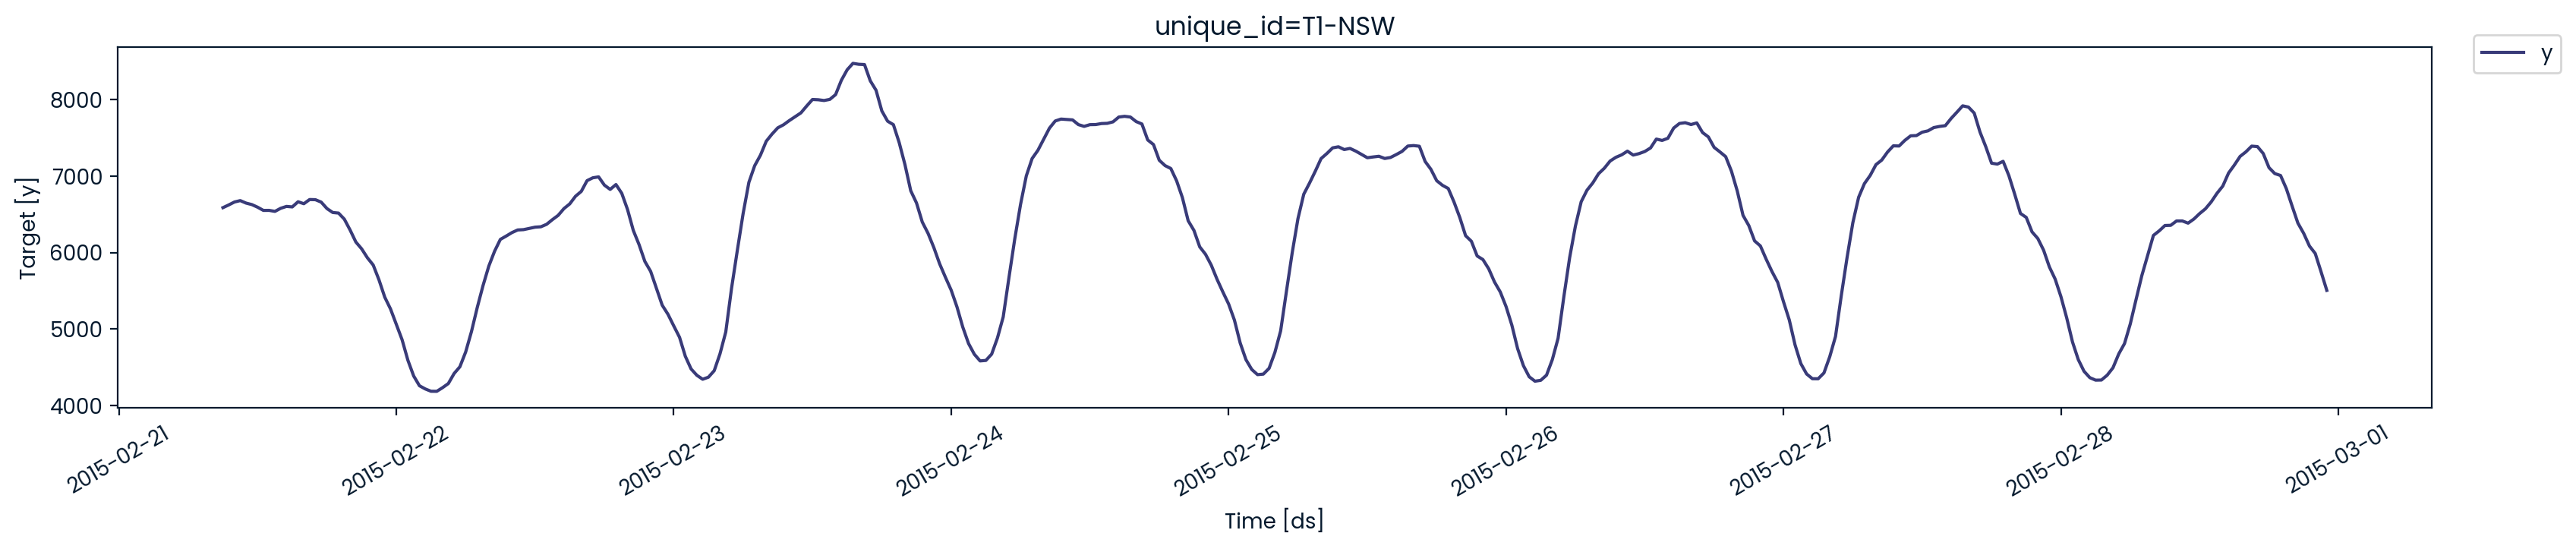

In [48]:
nixtla_client.plot(
    T1_df, 
    max_insample_length=365, 
)

In [50]:
test_df = T1_df.tail(144) # 3 days = (144 * 0.5h *  1 day/24h) 
train_df = T1_df.iloc[-1344:-144] # 25 days = (1200 *0.5h * 1 day/24h)

In [51]:
predict_df = nixtla_client.forecast(
    df=train_df,
    h=144,                            
    level=[90],                        # Generate a 90% confidence interval
    finetune_steps=60,                 # Specify the number of steps for fine-tuning
    finetune_loss='mae',               # Use the MAE as the loss function for fine-tuning
    model='timegpt-1-long-horizon',                 # Use the model for long-horizon forecasting
    time_col='ds',
    target_col='y'
)

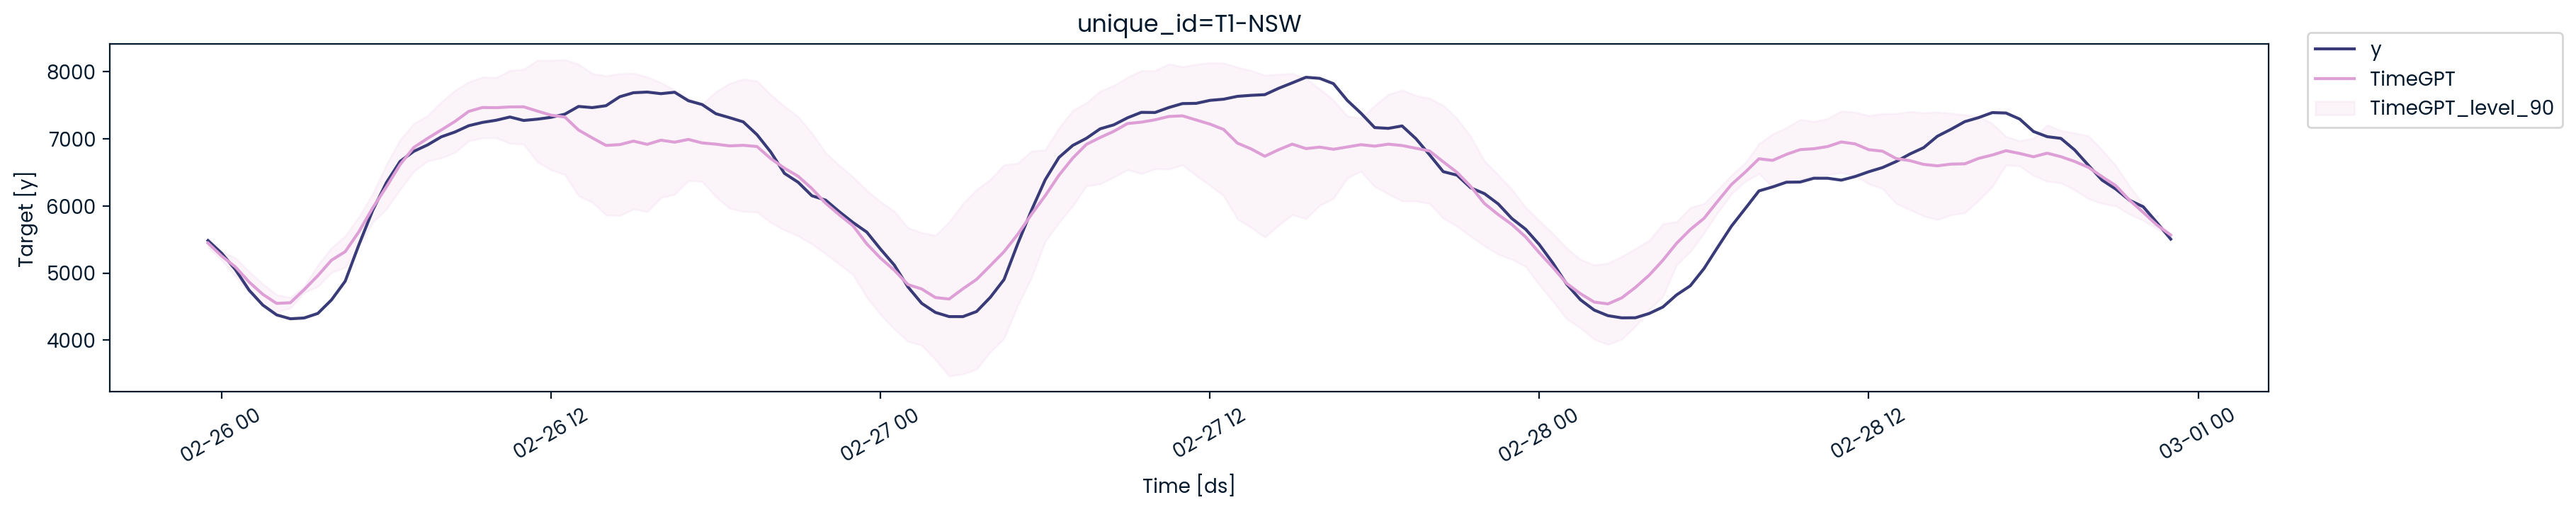

In [52]:
nixtla_client.plot(test_df, predict_df, models=['TimeGPT'], level=[90], time_col='ds', target_col='y')

In [82]:
from utilsforecast.losses import mae, rmse, smape
from utilsforecast.evaluation import evaluate

In [54]:

predict_df['ds'] = pd.to_datetime(predict_df['ds'])
test_df = pd.merge(test_df, predict_df, 'left', ['ds','unique_id'])
evaluation = evaluate(
    test_df,
    metrics=[mae, rmse, smape],
    models=["TimeGPT"],
    target_col="y",
    id_col = "unique_id"
)

average_metrics = evaluation.groupby('metric')["TimeGPT"].mean()
average_metrics

metric
mae      316.972341
rmse     410.623551
smape      0.025119
Name: TimeGPT, dtype: float64

In [55]:
test_df = demand_df.groupby('unique_id').tail(144) # 3 days                                                    
train_df = demand_df.groupby('unique_id').apply(lambda group: group.iloc[-1344:-144]).reset_index(drop=True) # 25 days 

In [56]:
predict_df = nixtla_client.forecast(
    df=train_df,
    h=144,                            
    level=[90],                        
    finetune_steps=60,                 
    finetune_loss='mae',               
    model='timegpt-1-long-horizon',    
    time_col='ds',
    target_col='y',
    id_col='unique_id'
)

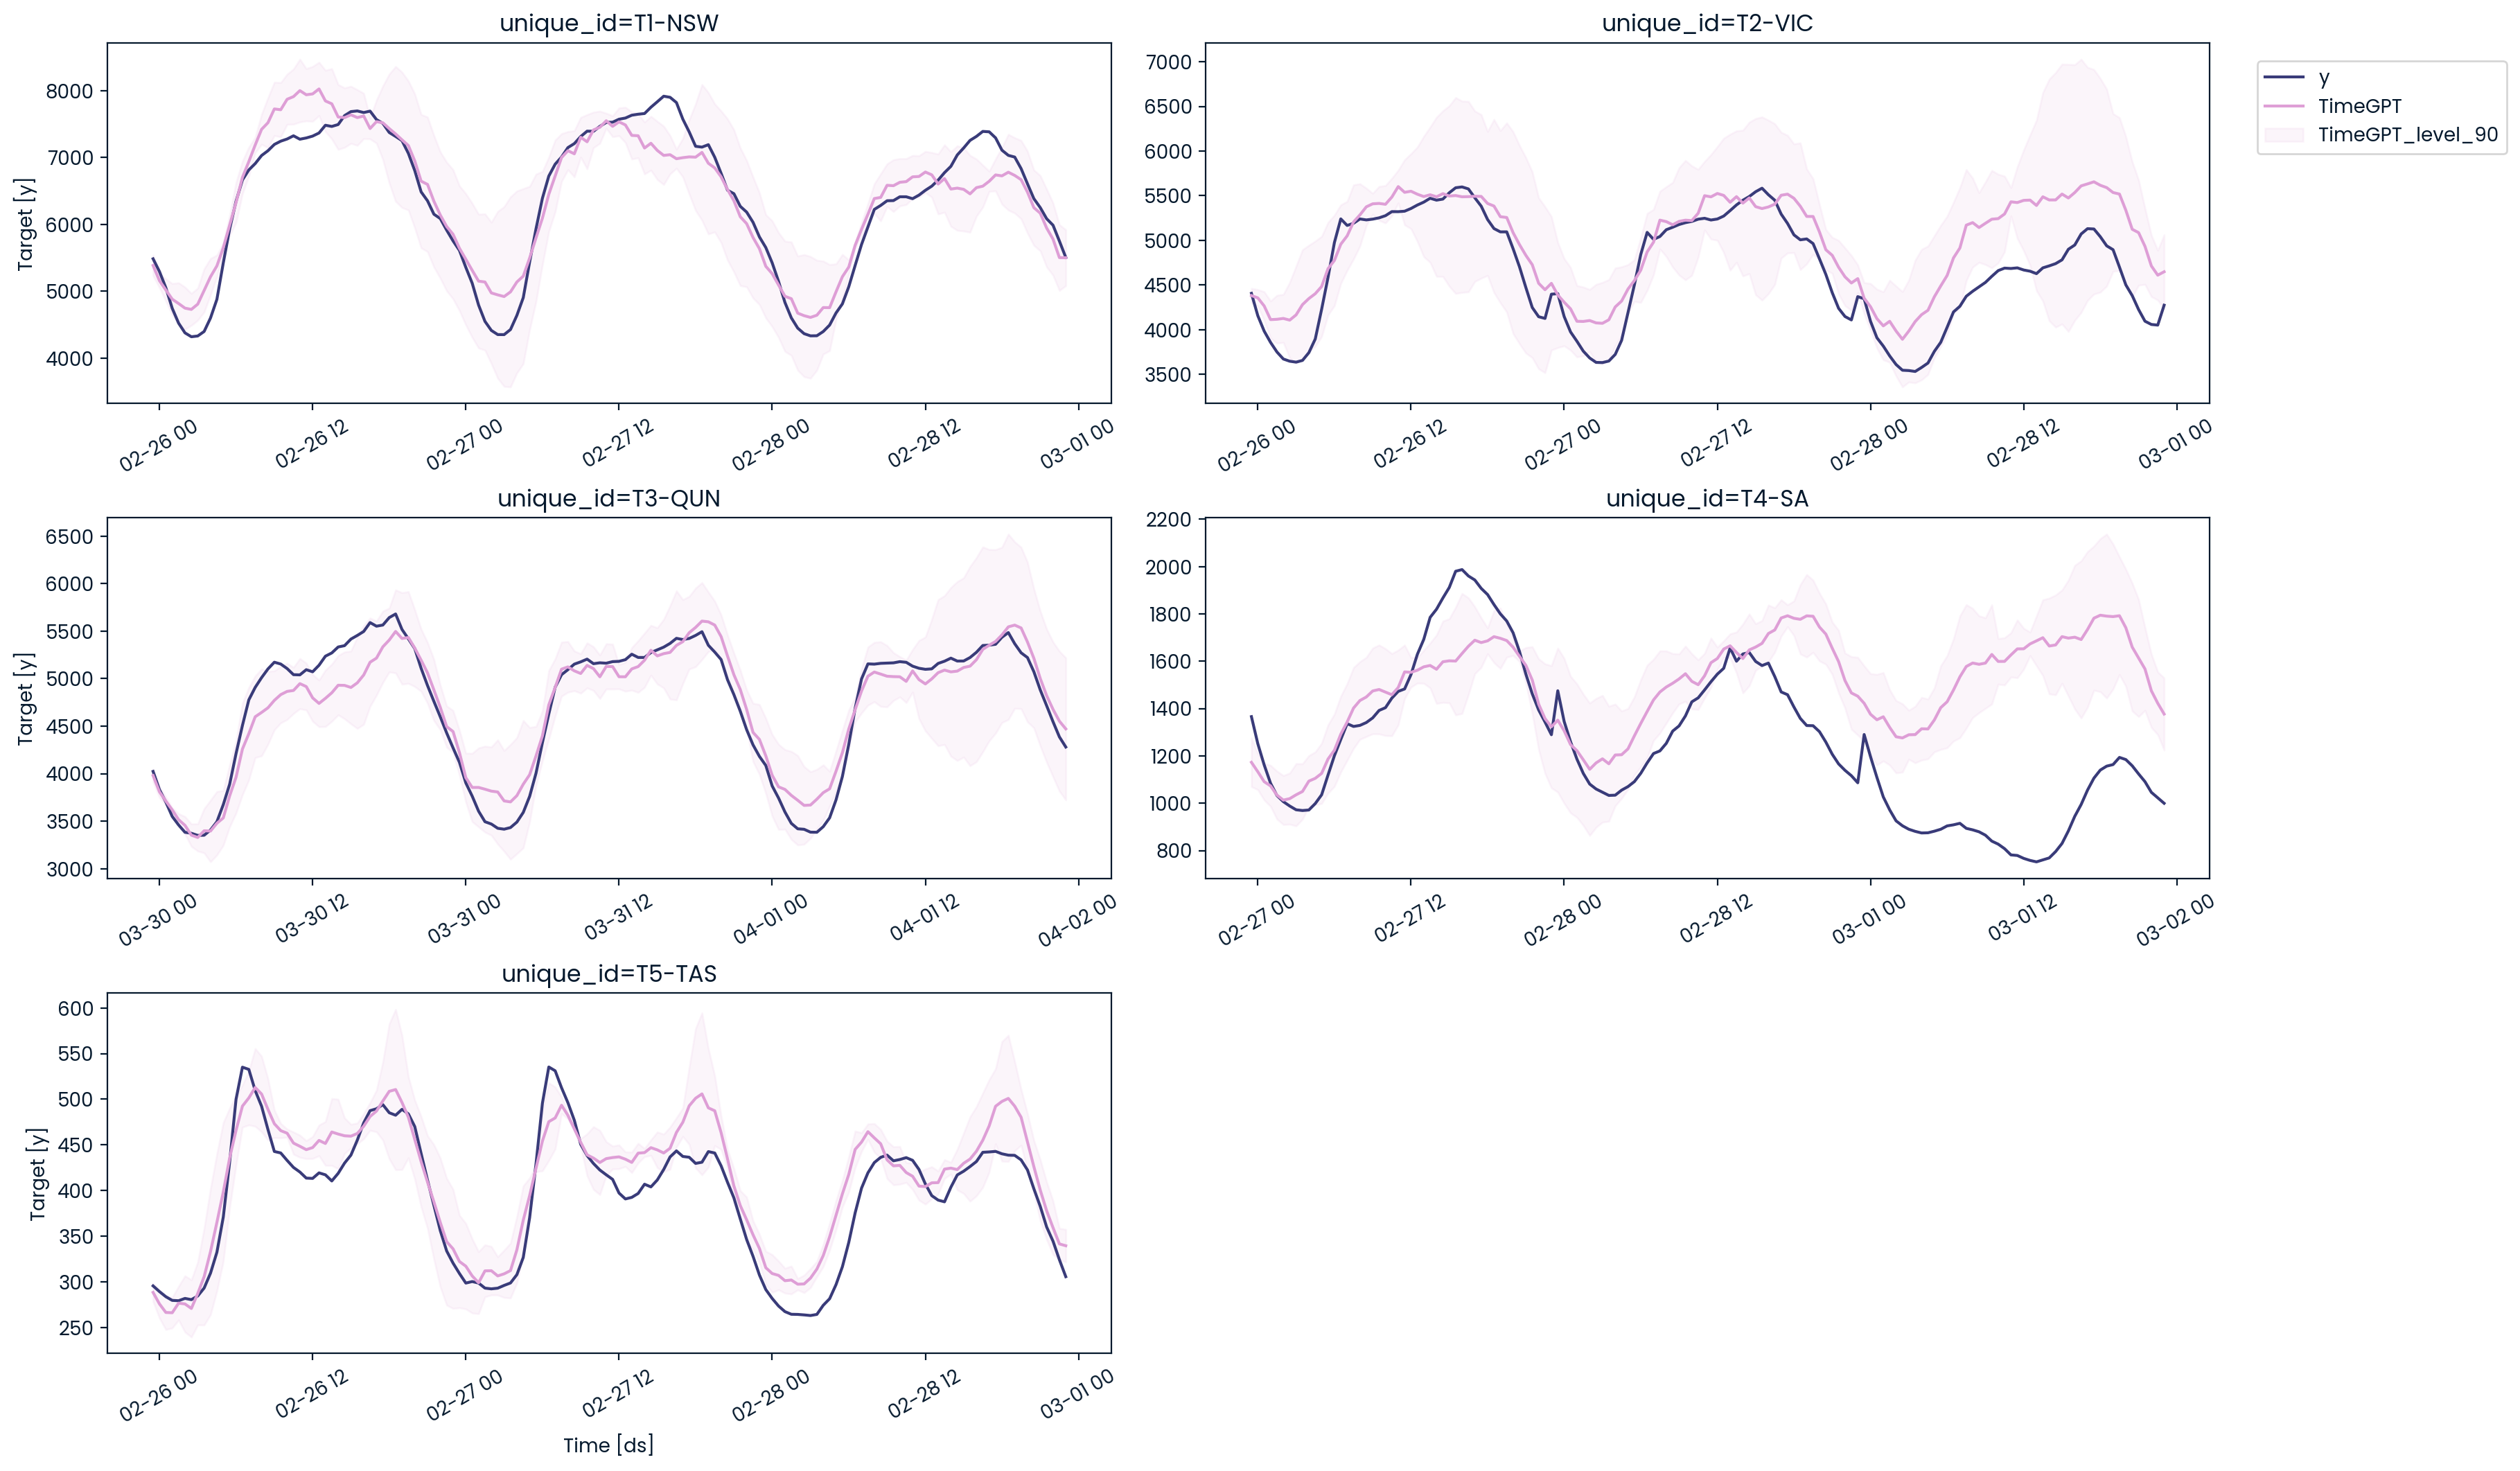

In [57]:
nixtla_client.plot(test_df, predict_df, models=['TimeGPT'], level=[90], time_col='ds', target_col='y')

In [58]:
predict_df['ds'] = pd.to_datetime(predict_df['ds'])
test_df = pd.merge(test_df, predict_df, 'left', ['ds','unique_id'])

In [59]:
evaluation = evaluate(
    test_df,
    metrics=[mae, rmse, smape],
    models=["TimeGPT"],
    target_col="y",
    id_col = "unique_id"
)

average_metrics = evaluation.groupby('metric')["TimeGPT"].mean()
average_metrics

metric
mae      224.736977
rmse     284.733911
smape      0.045372
Name: TimeGPT, dtype: float64

In [78]:
timegpt_cv_df = nixtla_client.cross_validation(
    T1_df, 
    h=5, 
    n_windows=5, 
    time_col='ds', 
    target_col='y', 
    freq='H',
)
timegpt_cv_df.head()

,unique_id,ds,cutoff,y,TimeGPT
0,T1-NSW,2015-02-27 22:30:00,2015-02-27 21:30:00,6030.435828,6292.9165
1,T1-NSW,2015-02-27 23:30:00,2015-02-27 21:30:00,5652.669954,6360.9720
2,T1-NSW,2015-02-28 00:30:00,2015-02-27 21:30:00,5145.417668,6480.4310
3,T1-NSW,2015-02-28 01:30:00,2015-02-27 21:30:00,4601.191954,6627.3125
4,T1-NSW,2015-02-28 02:30:00,2015-02-27 21:30:00,4365.049638,6834.9927


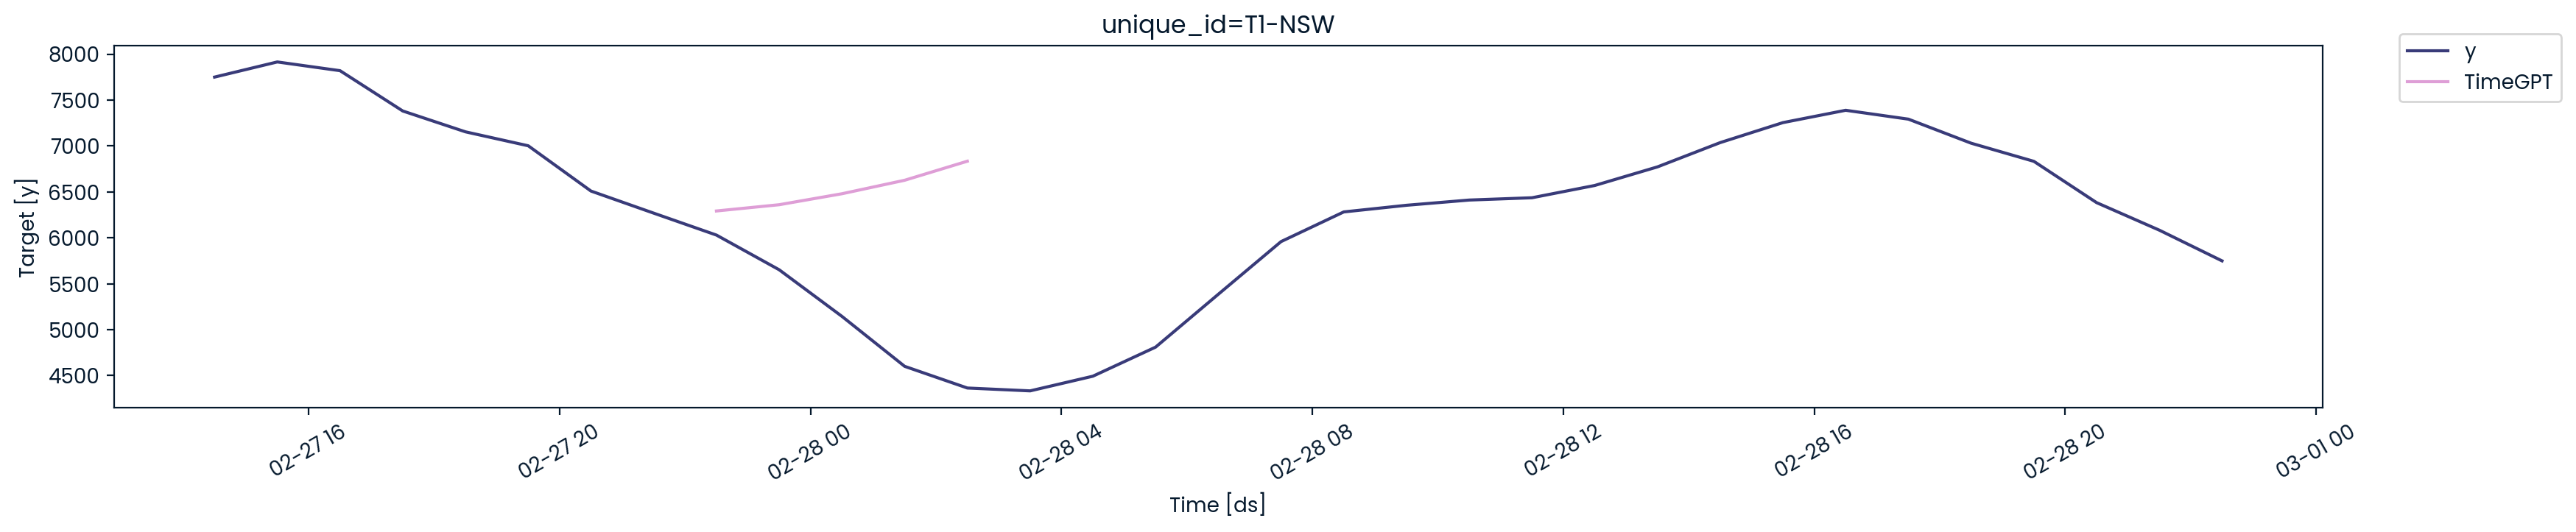

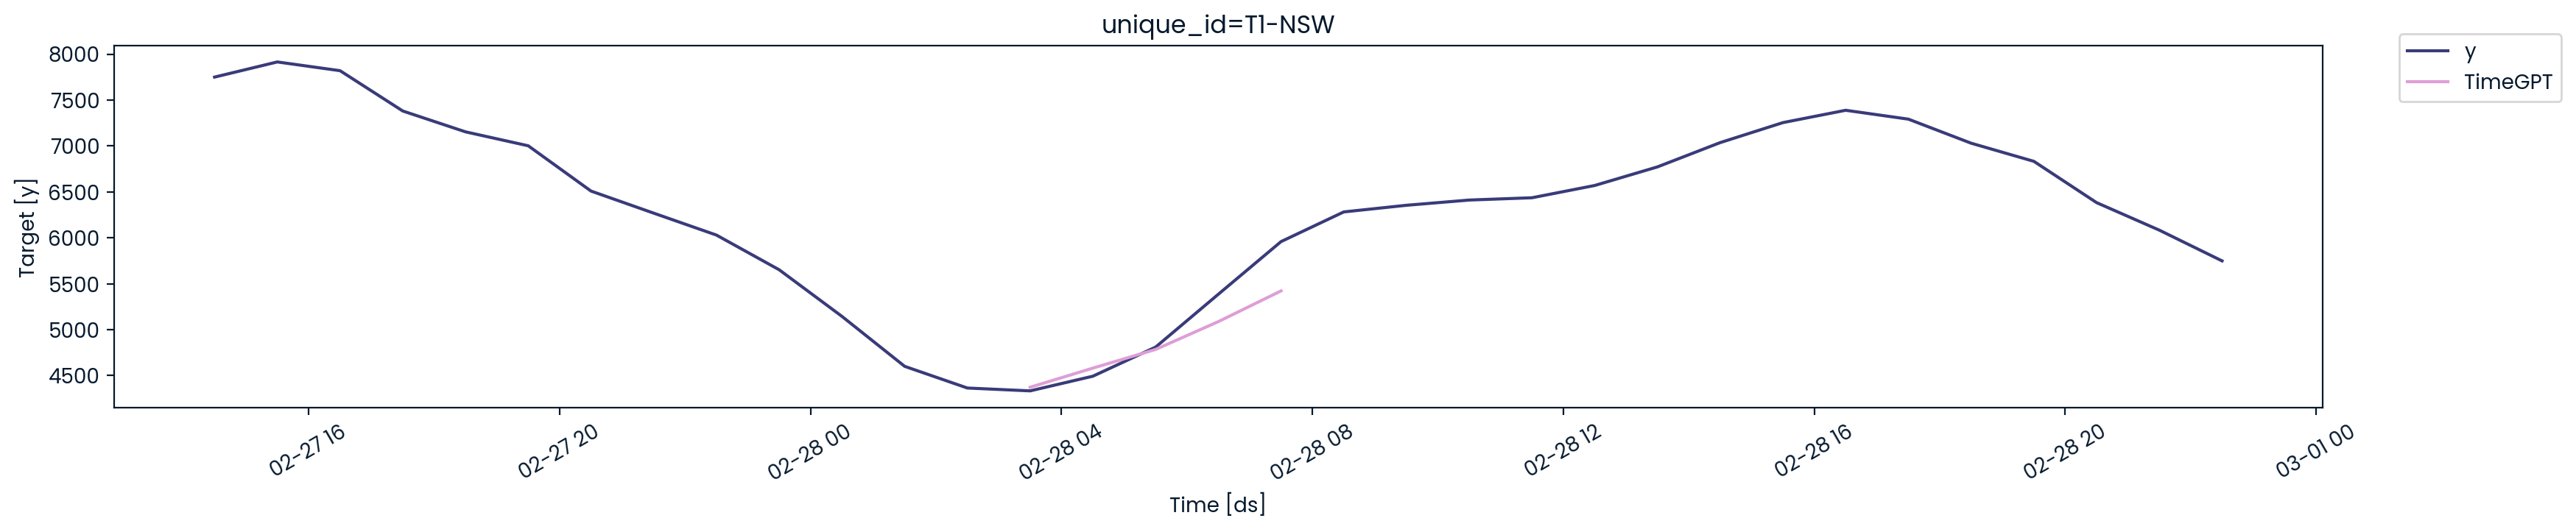

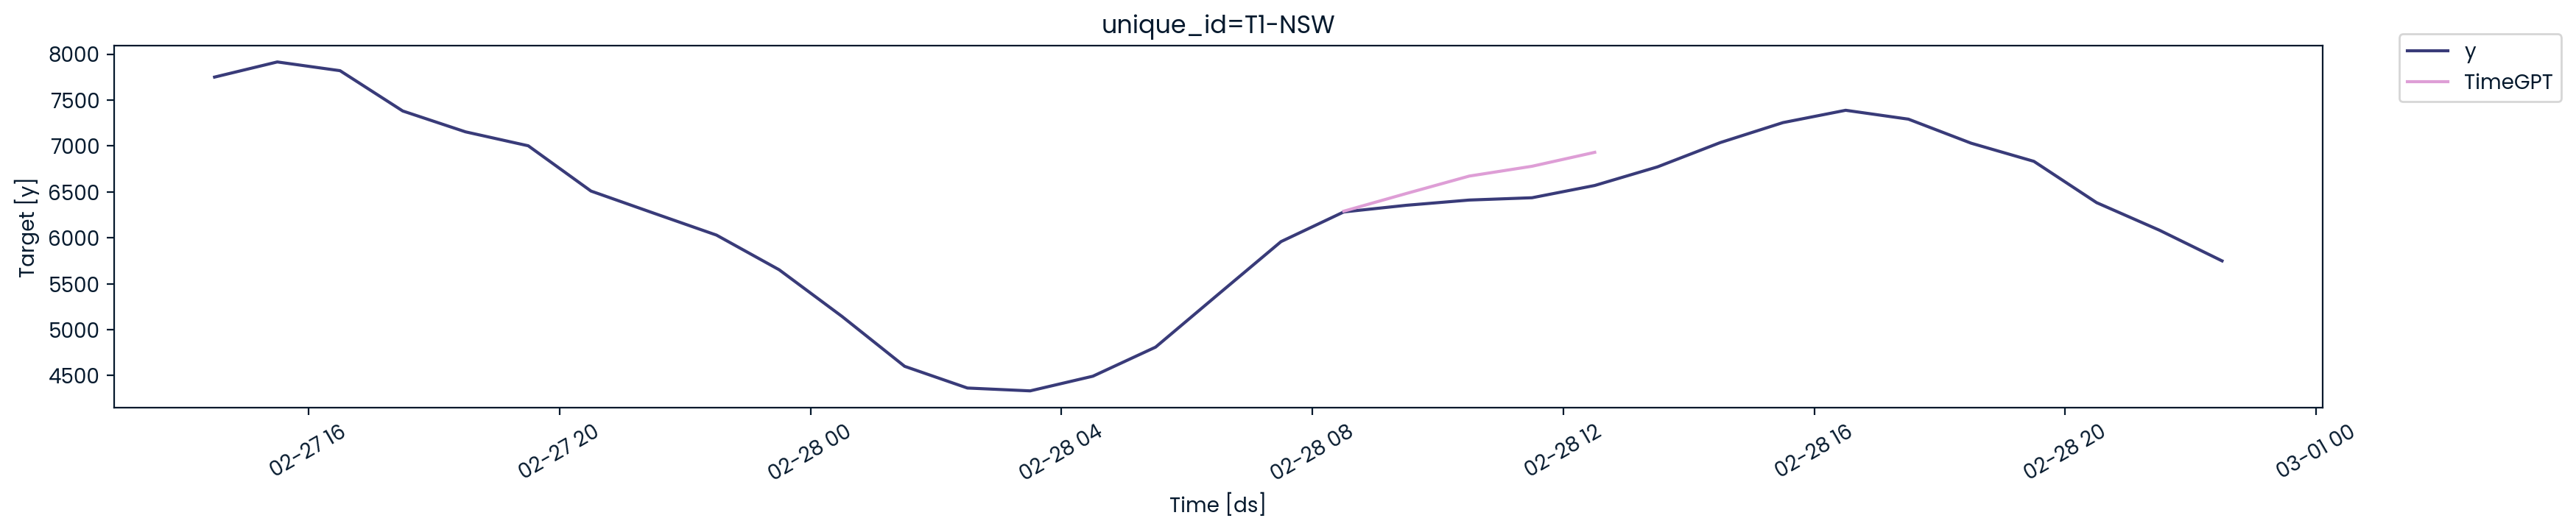

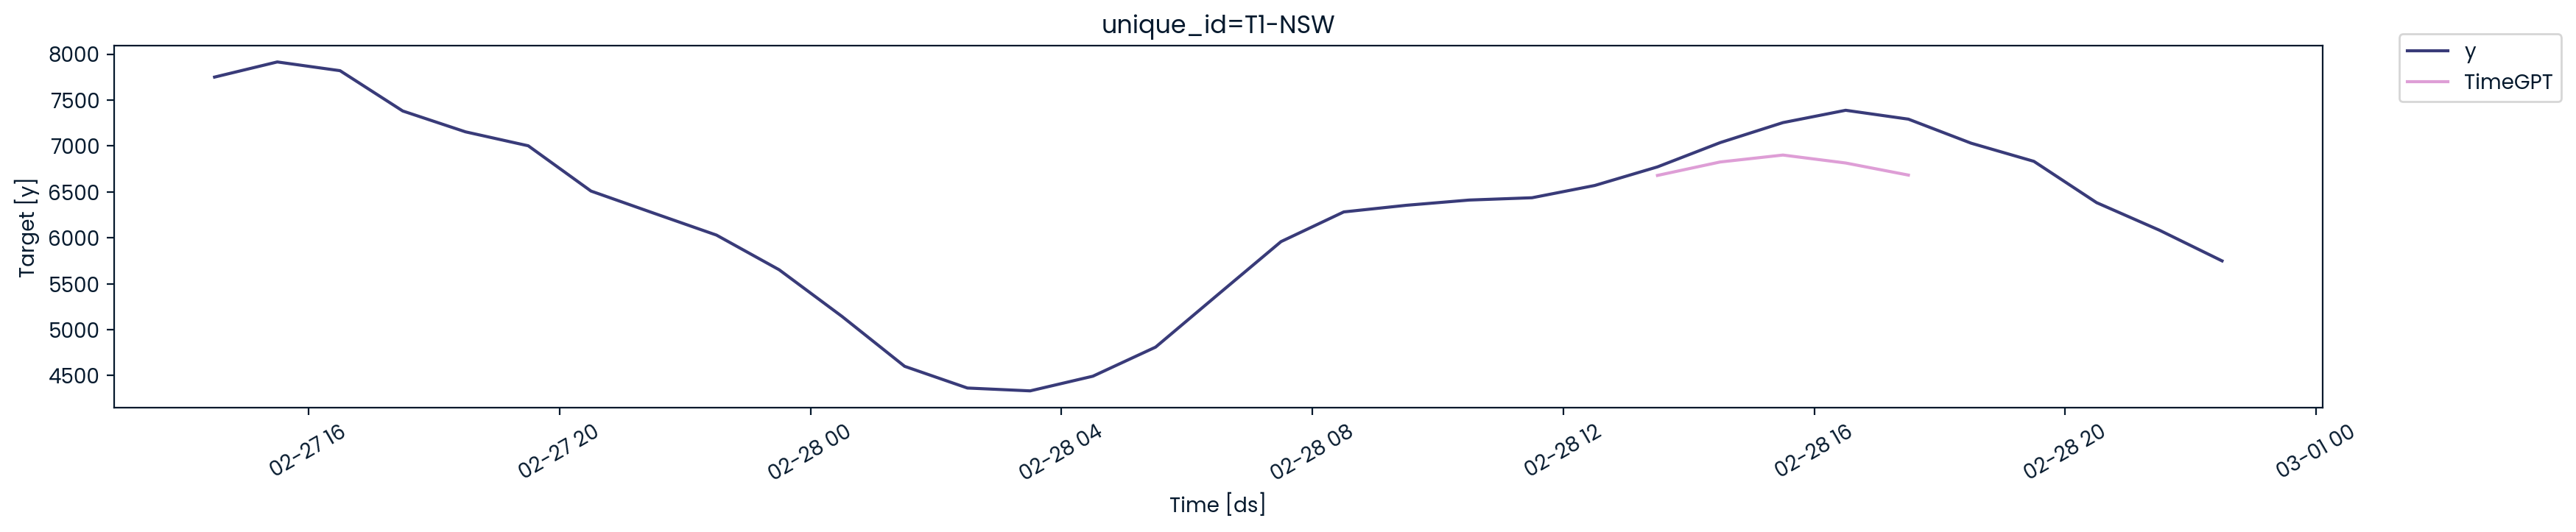

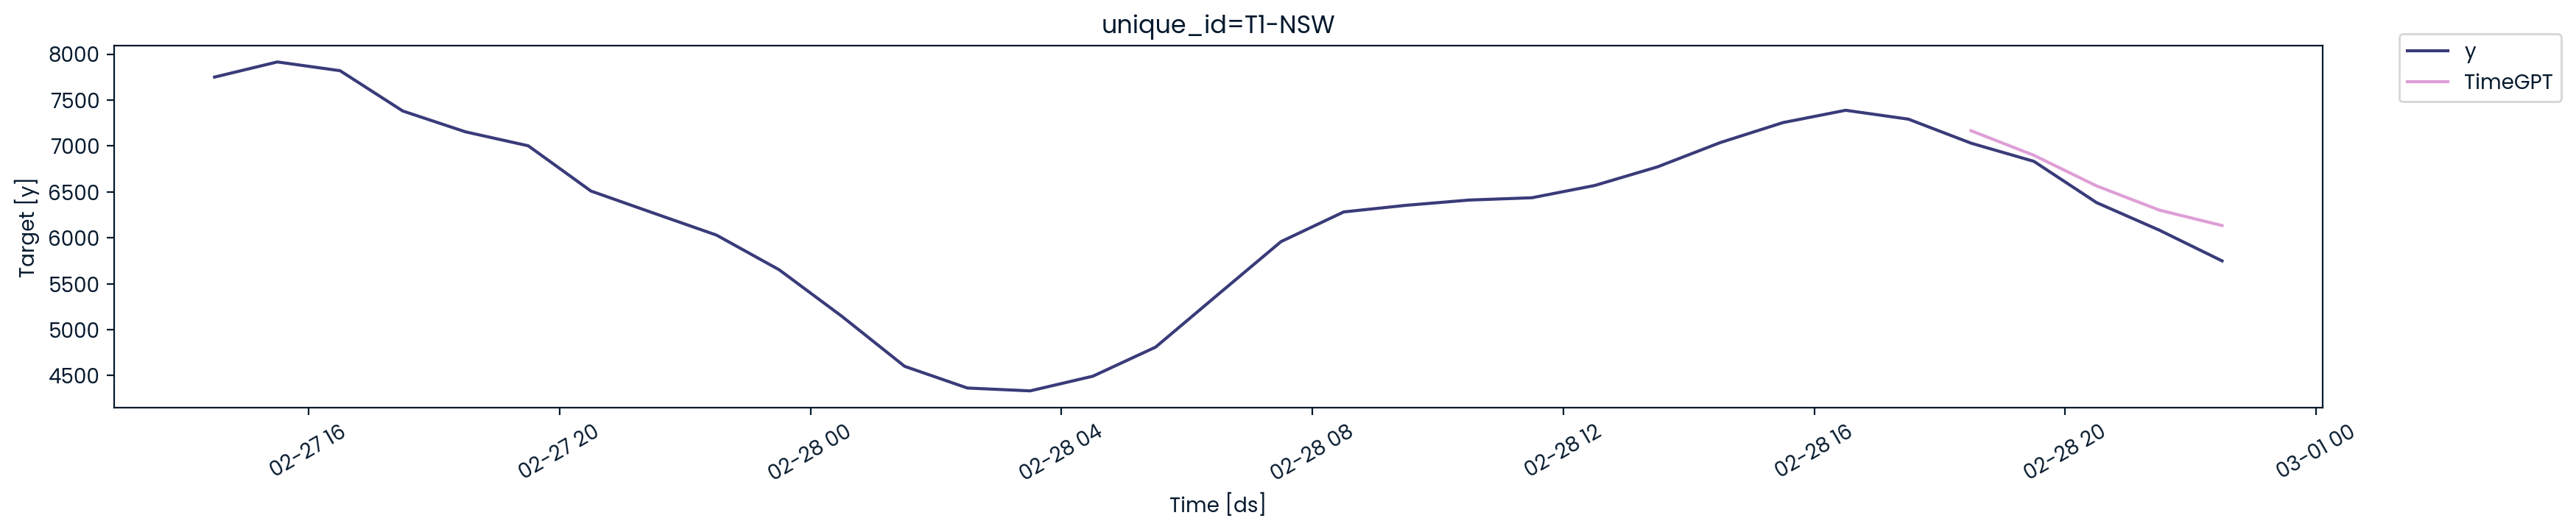

In [79]:
cutoffs = timegpt_cv_df['cutoff'].unique()
for cutoff in cutoffs:
    fig = nixtla_client.plot(
        T1_df.tail(100), 
        timegpt_cv_df.query('cutoff == @cutoff').drop(columns=['cutoff', 'y']),
        time_col='ds', 
        target_col='y'
    )
    display(fig)

In [81]:
timegpt_cv_df

,unique_id,ds,cutoff,y,TimeGPT
0,T1-NSW,2015-02-27 22:30:00,2015-02-27 21:30:00,6030.435828,6292.9165
1,T1-NSW,2015-02-27 23:30:00,2015-02-27 21:30:00,5652.669954,6360.9720
2,T1-NSW,2015-02-28 00:30:00,2015-02-27 21:30:00,5145.417668,6480.4310
3,T1-NSW,2015-02-28 01:30:00,2015-02-27 21:30:00,4601.191954,6627.3125
4,T1-NSW,2015-02-28 02:30:00,2015-02-27 21:30:00,4365.049638,6834.9927
5,T1-NSW,2015-02-28 03:30:00,2015-02-28 02:30:00,4333.986724,4373.3790
6,T1-NSW,2015-02-28 04:30:00,2015-02-28 02:30:00,4493.683134,4581.7456
7,T1-NSW,2015-02-28 05:30:00,2015-02-28 02:30:00,4810.356626,4785.1055
8,T1-NSW,2015-02-28 06:30:00,2015-02-28 02:30:00,5386.108114,5087.9644
9,T1-NSW,2015-02-28 07:30:00,2015-02-28 02:30:00,5959.459872,5422.6660


In [83]:
evaluation = evaluate(
    timegpt_cv_df,
    metrics=[mae, rmse, smape],
    models=["TimeGPT"],
    target_col="y",
    id_col = "cutoff"
)
evaluation

,cutoff,metric,TimeGPT
0,2015-02-27 21:30:00,mae,1360.371932
1,2015-02-28 02:30:00,mae,197.528691
2,2015-02-28 07:30:00,mae,220.340328
3,2015-02-28 12:30:00,mae,368.028856
4,2015-02-28 17:30:00,mae,197.361461
5,2015-02-27 21:30:00,rmse,1584.842685
6,2015-02-28 02:30:00,rmse,278.201978
7,2015-02-28 07:30:00,rmse,257.921647
8,2015-02-28 12:30:00,rmse,419.124648
9,2015-02-28 17:30:00,rmse,224.376318


In [84]:
average_metrics = evaluation.groupby('metric')["TimeGPT"].mean()
average_metrics

metric
mae      468.726253
rmse     552.893455
smape      0.039253
Name: TimeGPT, dtype: float64

# LGBM

In [66]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Function to calculate SMAPE (not converting into percentage)
def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Assuming 'ds' is the date/time column and 'y' is the target variable
T1_df['ds'] = pd.to_datetime(T1_df['ds'])

# Filter the DataFrame to include only the specified datetime range
start_date = '2015-02-27T13:00:00'
end_date = '2015-02-28T23:00:00'
T1_df = T1_df[(T1_df['ds'] >= start_date) & (T1_df['ds'] <= end_date)]

# Convert 'ds' to a numerical value (e.g., timestamp)
T1_df['ds_num'] = T1_df['ds'].apply(lambda x: x.timestamp())

# Create lag and window features
for lag in range(1, 4):
    T1_df[f'lag_{lag}'] = T1_df['y'].shift(lag)

T1_df['rolling_mean'] = T1_df['y'].rolling(window=3).mean()
T1_df['rolling_std'] = T1_df['y'].rolling(window=3).std()

# Drop NaN values resulting from lag and rolling operations
T1_df.dropna(inplace=True)

# Select features for the model
X = T1_df[['ds_num', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean', 'rolling_std']]
y = T1_df['y']

# Time series split
tscv = TimeSeriesSplit(n_splits=5)
mae_scores = []
rmse_scores = []
smape_scores = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Initialize and train the LGBM model
    model = lgb.LGBMRegressor(force_row_wise=True, verbosity=-1)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    smape_value = smape(y_test, y_pred)

    mae_scores.append(mae)
    rmse_scores.append(rmse)
    smape_scores.append(smape_value)

# Convert the metrics into a DataFrame
mae_avg = np.mean(mae_scores)
rmse_avg = np.mean(rmse_scores)
smape_avg = np.mean(smape_scores)

metrics_df = pd.DataFrame({
    'metric': ['MAE', 'RMSE', 'SMAPE'],
    'LGBM': [mae_avg, rmse_avg, smape_avg]
})

# Display the DataFrame
metrics_df


,metric,LGBM
0,MAE,954.367888
1,RMSE,1008.509392
2,SMAPE,0.155241
